# Filtracja Non-Local Means

## Definicja

Kolejny "poziom wtajemniczenia" w zagadnienie filtracji obrazów to metoda Non-Local Means (NLM).
Została ona zaproponowana w pracy *"A non-local algorithm for image denoising"* (autorzy: Antoni Buades, Bartomeu Coll i Jean Michel Morel) na konferencji CVPR w 2005 roku.

Filtr NLM dany jest zależnością:

\begin{equation}
\hat{I}(\mathbf{x}) = \sum_{\mathbf{p} \in V(\mathbf{x})} w(\mathbf{p},\mathbf{x})I(\mathbf{p})
\tag{1}
\end{equation}

gdzie:
- $I$ - obraz wejściowy,
- $\hat{I}$ - obraz wyjściowy (przefiltrowany),
- $\mathbf{x}$ - współrzędne piksela obrazu,
- $V(\mathbf{x})$ - obszar poszukiwań piksela, dla którego przeprowadzana jest filtracja,
- $w$ - waga punktu $\mathbf{p}$ z obszaru poszukiwań.

Wróćmy na chwilę do filtracji bilateralnej. Tam waga danego piksela z kontekstu zależała od dwóch czynników - odległości przestrzennej pomiędzy pikselami oraz różnicy w jasności/kolorze pomiędzy pikselami (tzw. przeciwdziedzina).
Filtr NLM stanowi uogólnienie tej metody - do obliczania wag nie wykorzystuje się już pojedynczych pikseli ($\mathbf{p}$ i $\mathbf{x}$), a lokalne konteksty ($N(\mathbf{p})$ i $N(\mathbf{x})$).

Waga $w$ dana jest następującą zależnością:

\begin{equation}
w(\mathbf{p},\mathbf{x}) = \frac{1}{Z(\mathbf{x})}\exp(-\frac{|| v(N(\mathbf{p})) - v(N(\mathbf{x})) ||^2_{2}}{\alpha \sigma^2})
\tag{2}
\end{equation}

gdzie:
\begin{equation}
Z(\mathbf{x}) = \sum_{\mathbf{p} \in V(\mathbf{x})} \exp(-\frac{|| v(N(\mathbf{p})) - v(N(\mathbf{x})) ||^2_{2}}{\alpha \sigma^2})
\tag{3}
\end{equation}

- $|| \cdot ||$ - jest normą $L_2$ odległości pomiędzy dwoma kontekstami,
- $v$ oznacza mnożenie punktowe kontekstu $N$ przez dwuwymiarową maskę Gaussa o odpowiadających kontekstowi wymiarach,
- $\alpha$ > 0 - parametr sterujący filtracją,
- $\sigma$ - parametr szumu stacjonarnego występującego na obrazie (w przypadku szumu niestacjonarnego, parametr $\sigma$ musi zostać dopasowany lokalnie tj. $\sigma = \sigma(\mathbf{x})$).

## Analiza działania

Zastanówmy sie teraz jak działa filtra NLM. Najprościej to zrozumieć na rysunku.

![Ilustracja NLM](https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/nlm.png)

1. Dla rozważanego piksela $\mathbf{x}$ definiujemy obszar poszukiwań $V(\mathbf{x})$. Uwaga - obszar poszukiwań ($V$) jest jednostką większą niż otocznie/kontekst ($N$).

2. Następnie, dla każdego z pikseli $\mathbf{p} \in  V(\mathbf{x})$ oraz samego $\mathbf{x}$ definiujemy otocznie/kontekst odpowiednio $N(\mathbf{p})$ i $N(\mathbf{x})$.

3. Wracamy do równania definiującego wagę  $w(\mathbf{p},\mathbf{x})$, a konkretnie do wyrażenia $|| v(N(\mathbf{p})) - v(N(\mathbf{x})) ||$. Przeanalizujmy co ono oznacza. Mamy dwa otoczenia: $N(\mathbf{p})$ i $N(\mathbf{x})$. Każde z nich mnożymy przez odpowiadającą maskę Gaussa - funkcja $v$. Otrzymujemy dwie macierze, które odejmujemy od siebie punktowo. Następnie obliczamy kwadrat z normy ($L_2$ definiujemy jako $||X||_2 = \sqrt{\sum_k|X_k|^2}$. Otrzymujemy zatem jedną liczbę, która opisuje nam podobieństwo otoczeń pikseli $\mathbf{x}$ i $\mathbf{p}$. Mała wartość oznacza otoczenia zbliżone, duża - różniące się. Ponieważ, z dokładnością do stałych, liczba ta stanowi wykładnik funkcji $e^{-x}$, to ostatecznie waga jest zbliżona do 1 dla otoczeń podobnych, a szybko maleje wraz z malejącym podobieństwem kontekstów.

4. Podsumowując: jak wynika z powyższej analizy filtr NLM to taki filtr bilateralny, w którym zamiast pojedynczych pikseli porównuje się ich lokalne otoczenia. Wpływa to pozytywnie na jakość filtracji, niestety kosztem złożoności obliczeniowej.

## Implementacja

W ramach zadania należy zaimplementować filtr NLM, ocenić jego działanie w porównaniu do filtra Gaussa i bilateralnego oraz dokonać pomiaru czasu obliczeń (dla trzech wymienionych metod).

Jak już się zrozumie jak działa NLM, jego implementacja jest dość prosta.
Wartość parametru $\alpha$ należy dobrać eksperymentalnie.
Nie należy także "przesadzić" z rozmiarem obszaru poszukiwań (np. 11x11) oraz kontekstu (5x5 lub 3x3).

Wskazówki do implementacji:
- algorytm sprowadza się do dwóch podwójnych pętli for: zewnętrzne po pikselach, wewnętrzne po kolejnych obszarach przeszukań,
- przed realizacją trzeba przemyśleć problem pikseli brzegowych - de facto problemów jest kilka. Po pierwsze nie dla każdego piksela można wyznaczyć pełny obszar przeszukań (tu propozycja, aby filtrację przeprowadzać tylko dla pikseli z pełnym obszarem). Po drugie, ponieważ rozpatrujemy konteksty, to nawet dla piksela o "pełnym" obszarze przeszukań, będą istnieć piksele, dla których nie pełnych kontekstów (sugestia - powiększyć obszar przeszukać, tak aby zawierał konteksty). Ostatni problem jest bardziej techniczny/implementacyjny. Jeśli w kolejnych iteracjach "jawnie" wytniemy fragment o rozmiarach obszaru przeszukiwań, to znowu pojawi się problem brzegowy - tu można albo wyciąć nieco większy obszar, albo cały czas "pracować" na obrazie oryginalnym ("żonglerka indeksami").
- warto sprawdzać indeksy i rozmiary "wycinanych" kontekstów,
- wagi wyliczamy w trzech krokach:
    - obliczenia dla $N(\mathbf{x})$ + inicjalizacja macierzy na wagi,
    - podwójna pętla, w której przeprowadzamy obliczenia dla kolejnych $N(\mathbf{p})$ oraz wyliczamy wagi,
    - normalizacja macierzy wag oraz końcowa filtracja obszaru w wykorzystaniem wag.
- uwaga, obliczenia trochę trwają, nawet dla obrazka 256x256 i względnie niewielkich obszaru przeszukań i kontesktu.

Efekt końcowy:
- porównanie wyników metod: filtr Gaussa, filtr bilateralny oraz filtr NLM (2-3 zdania komentarza),
- porównanie czasu działania powyższych metod (1 zdanie komentarza).


In [16]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.io import loadmat
import math
import os
import copy

if not os.path.exists("MR_data.mat") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/MR_data.mat --no-check-certificate
mr_data = loadmat('MR_data.mat')
plt.gray()

def fgaussian(size, sigma):
     m = n = size
     h, k = m//2, n//2
     x, y = np.mgrid[-h:h+1, -k:k+1]
     g = np.exp(-(x**2 + y**2)/(2*sigma**2))
     return g /g.sum() 
       
def mesh(fun, size):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    X = np.arange(-size//2, size//2, 1)
    Y = np.arange(-size//2, size//2, 1)
    X, Y = np.meshgrid(X, Y)
    Z = fun
    ax.plot_surface(X, Y, Z)
    
    plt.show()

<Figure size 640x480 with 0 Axes>

C:\Users\janro\AppData\Local\Temp\ipykernel_24916\4139181012.py:18: RuntimeWarning: invalid value encountered in divide
  out_V = out_V/np.abs(np.sum(out_V))


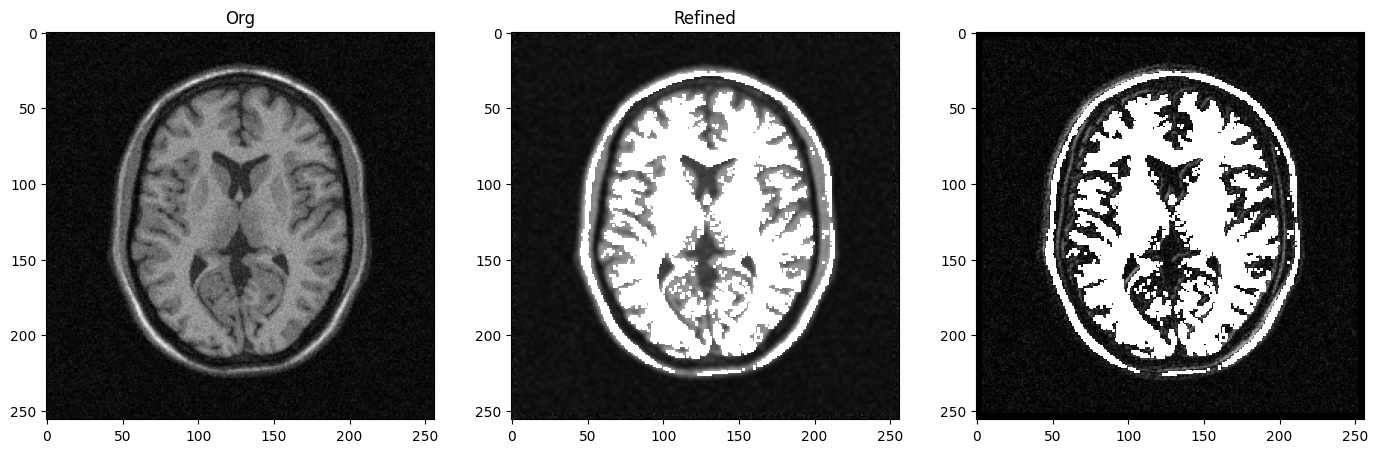

In [23]:
normscale = lambda diff, delta: np.exp(-(diff**2)/(2*delta**2))

def big_kon_func(V: np.ndarray, N_size, sigma, delta) -> float:
    out_V = copy.copy(V[N_size//2+1: V.shape[0]-N_size//2-1, N_size//2+1: V.shape[1]-N_size//2-1])
    src  =V[N_size//2+1: V.shape[0]-N_size//2-1, N_size//2+1: V.shape[1]-N_size//2-1]
    for row in range(N_size//2+1, V.shape[0]-N_size//2-1):
        for col in  range(N_size//2+1, V.shape[1]-N_size//2-1):
            gauss = fgaussian(N_size, delta)
            N_x = V[V.shape[0]//2-N_size//2-1:V.shape[0]//2+N_size//2, V.shape[1]//2-N_size//2-1:V.shape[1]//2+N_size//2]
            N_x = np.multiply(N_x, gauss)
            N = V[row-N_size//2-1:row+N_size//2, col-N_size//2-1:col+N_size//2]
            # if False:
            #     print(out_V)
            #     print(row, col)
            #     print([row - N_size//2 - 1, col - N_size//2 - 1])
            w = normscale(np.sum(np.subtract(vN(N, gauss), N_x)), sigma)
            out_V[row - N_size//2 - 1, col - N_size//2 - 1] = w
    out_V = out_V/np.abs(np.sum(out_V))
    return np.abs(np.sum(np.multiply(out_V, src)))
    


def vN(N: np.ndarray, gauss: np.ndarray) -> float:
    xN = np.multiply(N, gauss)
    return xN/np.sum(xN)

def konvolucja_bil(srcc, V_size, N_size, sigma, delta):
    src = srcc.astype('float')
    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(17, 8)
    ax[0].imshow(src)
    ax[0].set_title("Org")
    gauss_filter = fgaussian(V_size, sigma)
    copsrc = src.copy().astype('float')
    for row in range(V_size//2+1, copsrc.shape[0]-V_size//2-1):
        for col in  range(V_size//2+1, copsrc.shape[1]-V_size//2-1):
            V = src[row-V_size//2-1:row+V_size//2, col-V_size//2-1:col+V_size//2]
            copsrc[row,col] = big_kon_func(V, N_size, sigma, delta)
            # if col == 110 and row == 70:
            #     print(gamma)
            #     print(kontext)
            #     print(adaptive_filter)
            #     print(copsrc[row, col])
            #     plt.imshow(kontext)
    ax[1].imshow(copsrc)
    ax[1].set_title("Refined")
    ax[2].imshow(np.abs(np.subtract(src, copsrc)))
    return copsrc

x = konvolucja_bil(mr_data['I_noisy1'], 7, 3, 3, 0.1)
